In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier
from joblib import dump
import warnings
warnings.filterwarnings("ignore")

In [862]:
plant_1 = pd.read_csv(r"C:\Freelance\Document\Plant_1_Generation_Data.csv")
plant_2 = pd.read_csv(r"C:\Freelance\Document\Plant_2_Generation_Data.csv")
solar = pd.read_csv(r"C:\Freelance\Document\SolarRecording.csv")

print(f'Plant 1 Duplicate \t: {plant_1.duplicated().sum()}')
print(f'Plant 2 Duplicate \t: {plant_2.duplicated().sum()}')
print(f'Solar Duplicate \t: {solar.duplicated().sum()}')

Plant 1 Duplicate 	: 0
Plant 2 Duplicate 	: 0
Solar Duplicate 	: 0


In [863]:
plant_1['DATE_TIME'] = pd.to_datetime(plant_1['DATE_TIME'])
plant_2['DATE_TIME'] = pd.to_datetime(plant_2['DATE_TIME'])
solar['DATE_TIME'] = pd.to_datetime(solar['Date'] + ' ' + solar['Time'])
solar = solar.drop(columns=['Date', 'Time', 'Unnamed: 0'])

In [864]:
all_plant = pd.concat([plant_1, plant_2], ignore_index=True)
solar['DATE_TIME'] = solar['DATE_TIME'].dt.round('15min')
all_plant = all_plant.merge(solar, on='DATE_TIME', how='left')

In [865]:
all_plant.isna().sum()
all_plant_test = all_plant.dropna()

In [879]:
all_plant_test.shape

(357760, 20)

In [866]:
def time_to_hours(time_str):
    h, m, s = map(int, time_str.split(':'))
    return h + m/60 + s/3600

all_plant_test['TimeSunRise'] = all_plant_test['TimeSunRise'].apply(time_to_hours)
all_plant_test['TimeSunSet'] = all_plant_test['TimeSunSet'].apply(time_to_hours)
all_plant_test['hour'] = pd.to_datetime(all_plant_test['DATE_TIME']).dt.hour.astype(int)
all_plant_test['hist_median_AC'] = all_plant_test.groupby(['SOURCE_KEY', 'hour'])['AC_POWER'].transform('median')
all_plant_test['day_of_year'] = all_plant_test['DATE_TIME'].dt.dayofyear

In [867]:
all_plant_test.describe()

,DATE_TIME,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,hour,hist_median_AC,day_of_year
count,357760,3.577600e+05,357760.000000,357760.000000,357760.000000,3.577600e+05,3.577600e+05,357760.000000,357760.000000,357760.000000,357760.000000,357760.000000,357760.000000,357760.000000,357760.000000,357760.000000,357760.000000,357760.000000
mean,2020-06-01 14:14:02.982725888,4.135499e+06,1604.096991,260.122765,3287.549955,3.303414e+08,1.474244e+09,225.642425,53.623997,30.433997,82.026227,132.150334,5.457392,6.178122,18.377380,11.676778,263.869125,153.090921
min,2020-05-15 00:00:00,4.135001e+06,0.000000,0.000000,0.000000,0.000000e+00,1.472724e+09,1.150000,41.000000,30.340000,15.000000,0.100000,0.000000,6.116667,18.133333,0.000000,0.000000,136.000000
25%,2020-05-24 18:30:00,4.135001e+06,0.000000,0.000000,22.500000,6.523269e+06,1.473569e+09,1.260000,49.000000,30.410000,71.000000,64.430000,3.370000,6.150000,18.250000,6.000000,0.000000,145.000000
50%,2020-06-02 12:07:30,4.135001e+06,0.000000,0.000000,2835.125000,7.274225e+06,1.474323e+09,4.430000,53.000000,30.430000,89.000000,138.770000,5.620000,6.183333,18.366667,12.000000,18.366667,154.000000
75%,2020-06-09 19:00:00,4.136001e+06,1064.993333,494.457143,5970.000000,2.826096e+08,1.474952e+09,366.920000,58.000000,30.460000,98.000000,174.660000,6.750000,6.200000,18.500000,18.000000,568.526667,161.000000
max,2020-06-17 23:45:00,4.136001e+06,14471.125000,1410.950000,9873.000000,2.247916e+09,1.475661e+09,1601.260000,71.000000,30.530000,103.000000,359.930000,20.250000,6.233333,18.633333,23.000000,996.326667,169.000000
std,NaN,4.999953e+02,3102.368224,369.385209,3029.246094,6.080793e+08,8.539951e+05,337.575816,5.657803,0.033215,19.586357,83.583776,2.791054,0.035001,0.149279,6.936816,336.794462,9.881620


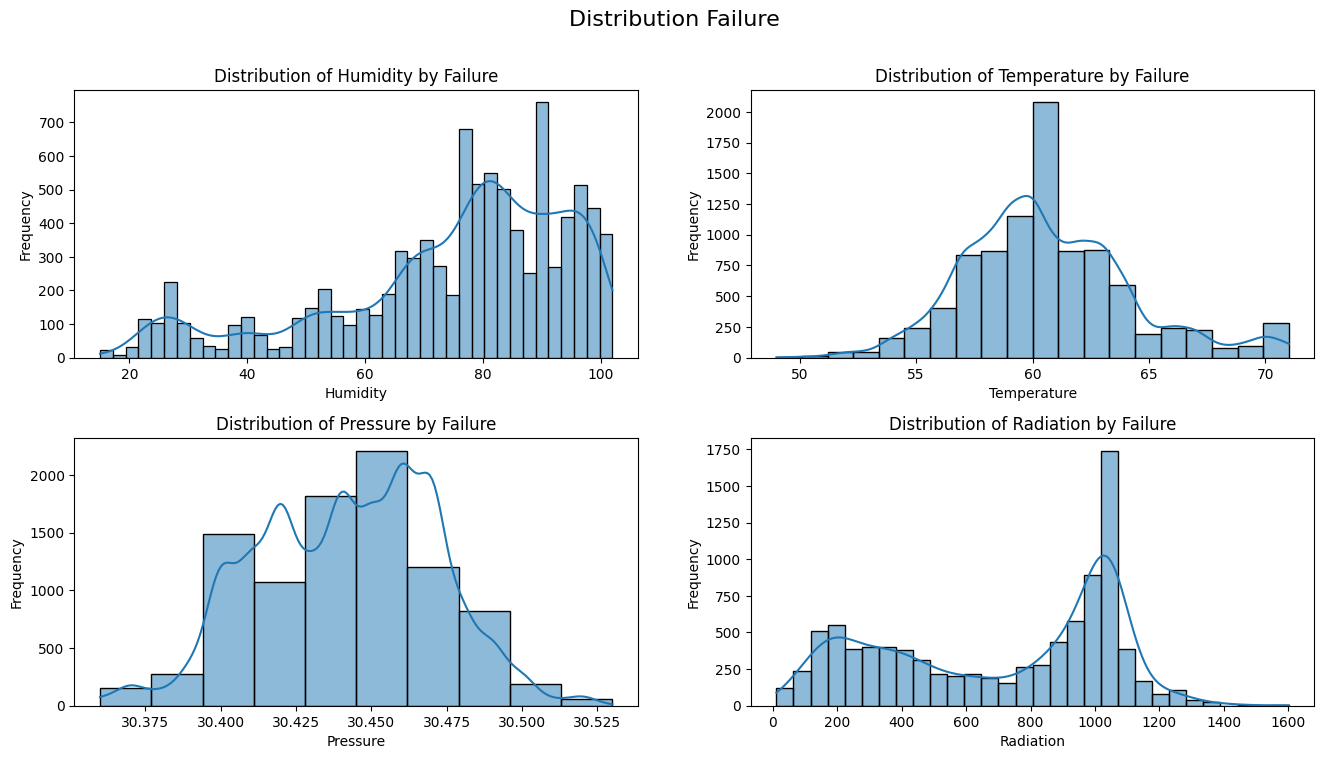

In [868]:
failure_data = all_plant_test[
    (all_plant_test['AC_POWER'] == 0) &
    (all_plant_test['hour'] >= all_plant_test['TimeSunRise']) &
    (all_plant_test['hour'] <= all_plant_test['TimeSunSet'] - 1)
]

fig, axes = plt.subplots(2, 2, figsize=(16, 8))

sns.histplot(failure_data['Humidity'], bins=40, kde=True, ax=axes[0,0])
axes[0,0].set_title("Distribution of Humidity by Failure")
axes[0,0].set_xlabel("Humidity")
axes[0,0].set_ylabel("Frequency")

sns.histplot(failure_data['Radiation'], bins=30, kde=True, ax=axes[1,1])
axes[1,1].set_title("Distribution of Radiation by Failure")
axes[1,1].set_xlabel("Radiation")
axes[1,1].set_ylabel("Frequency")

sns.histplot(failure_data['Temperature'], bins=20, kde=True, ax=axes[0,1])
axes[0,1].set_title("Distribution of Temperature by Failure")
axes[0,1].set_xlabel("Temperature")
axes[0,1].set_ylabel("Frequency")

sns.histplot(failure_data['Pressure'], bins=10, kde=True, ax=axes[1,0])
axes[1,0].set_title("Distribution of Pressure by Failure")
axes[1,0].set_xlabel("Pressure")
axes[1,0].set_ylabel("Frequency")

fig.suptitle('Distribution Failure', fontsize=16)
plt.subplots_adjust(hspace=0.3, wspace=0.2)
plt.show()

In [869]:
all_plant_test['failure'] = (
    ((all_plant_test['AC_POWER'] == 0) & 
     (all_plant_test['Humidity'] >= 80) &
     ((all_plant_test['Radiation'] <= 200) | (all_plant_test['Radiation'] >= 900)) &
     (all_plant_test['hour'] >= all_plant_test['TimeSunRise']) & 
     (all_plant_test['hour'] <= all_plant_test['TimeSunSet'] - 1))
).astype(int)

encoder = LabelEncoder()
all_plant_test['SOURCE_KEY'] = encoder.fit_transform(all_plant_test['SOURCE_KEY'])

In [870]:
train, temp = train_test_split(all_plant_test, test_size=0.4, random_state=42, stratify=all_plant_test['failure'])
test, valid = train_test_split(temp, test_size=0.5, random_state=42, stratify=temp['failure'])

In [871]:
def scale_dataset(dataframe, oversample=False):
    x = dataframe.drop(columns=['failure', 'DATE_TIME'])
    y = dataframe['failure']
    
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    if oversample:
        ros = RandomOverSampler()
        x, y = ros.fit_resample(x, y)
    data = np.hstack((x, np.reshape(y.values, (-1, 1))))
    return data, x, y

train, x_train, y_train = scale_dataset(train, oversample=True)
valid, x_valid, y_valid = scale_dataset(valid, oversample=False)
test, x_test, y_test = scale_dataset(test, oversample=False)

In [874]:
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model.fit(x_train, y_train)
y_pred = xgb_model.predict(x_test)

print("Classification Report:\n ", classification_report(y_test, y_pred))


Classification Report:
                precision    recall  f1-score   support

           0       1.00      1.00      1.00     71149
           1       0.98      1.00      0.99       403

    accuracy                           1.00     71552
   macro avg       0.99      1.00      0.99     71552
weighted avg       1.00      1.00      1.00     71552



In [875]:
scores = cross_val_score(xgb_model, x_train, y_train, cv=5)
print("Cross-Validation Scores:")
for i, score in enumerate(scores, 1):
    print(f"Fold {i}: {score:.4f}")
print(f"\nMean CV Score: {scores.mean():.4f}")
print(f"Standard Deviation: {scores.std():.4f}")

Cross-Validation Scores:
Fold 1: 1.0000
Fold 2: 0.9998
Fold 3: 1.0000
Fold 4: 0.9997
Fold 5: 0.9999

Mean CV Score: 0.9999
Standard Deviation: 0.0001


In [ ]:
best_model = xgb_model
dump(best_model,'SolarPlant.joblib')